# LifeSnaps Preprocessing Experiments

#### Import de llibreries necessaries

In [9]:
import warnings
warnings.filterwarnings('ignore')

# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform
import joblib

# Hyperparameter tuning
import optuna
from xgboost import XGBClassifier

# Imbalanced data pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Core utilities
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# Preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Model definitions
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Model selection and evaluation
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    learning_curve
)
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    make_scorer,
    roc_auc_score,
)

from ai_health_assistant.utils.train_helpers import train_models, append_results, plot_learning_curve, mat_confusio


# Configuració de pandas
pd.set_option('display.max_columns', None)

# Carrega de dades
df = pd.read_csv('../data/df_preprocessed.csv')
print(f"Shape: {df.shape}")


Shape: (2290, 40)


## Lectura de dades i split de train / test

In [10]:
# Comprovem quina es les estructura de les nostres dades faltants en el target
TARGET = 'TIRED'

df_complete = df.dropna(subset=[TARGET])

df_null_targets = df[df["TIRED"].isnull()]

print(f"Estructura dades amb target:\n{df_complete.shape}")
print(f"Estructura dades target null:\n{df_null_targets.shape}")

Estructura dades amb target:
(2290, 40)
Estructura dades target null:
(0, 40)


In [11]:
# Difinim X i el target y
# Prediccio de TIRED
X = df_complete.drop(columns=[TARGET])
y = df_complete[TARGET]

numerical_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

print(f"\nCol. numeriques ({len(numerical_features)}): \n{numerical_features}")
print(f"Col. categoriques ({len(categorical_features)}): \n{categorical_features}")




Col. numeriques (39): 
['num__bmi', 'num__calories', 'num__steps', 'num__lightly_active_minutes', 'num__moderately_active_minutes', 'num__very_active_minutes', 'num__sedentary_minutes', 'num__resting_hr', 'num__minutes_below_default_zone_1', 'num__minutes_in_default_zone_1', 'num__minutes_in_default_zone_2', 'num__minutes_in_default_zone_3', 'num__minutesToFallAsleep', 'num__minutesAsleep', 'num__minutesAwake', 'num__minutesAfterWakeup', 'num__sleep_efficiency', 'num__sleep_deep_ratio', 'num__sleep_light_ratio', 'num__sleep_rem_ratio', 'num__sleep_wake_ratio', 'num__daily_temperature_variation', 'num__rmssd', 'num__spo2', 'num__full_sleep_breathing_rate', 'num__wake_after_sleep_pct', 'num__stress_per_sleep_eff', 'num__hr_delta', 'num__steps_norm_cal', 'num__deep_sleep_score', 'num__active_sedentary_ratio', 'num__sleep_activity_balance', 'num__bmi_hr_interaction', 'num__sleep_quality_index', 'num__hr_zone_variability', 'cat__age_<30', 'cat__age_>=30', 'cat__gender_FEMALE', 'cat__gender

### Train / Test Split

In [12]:
# Estratifiquem respecte un dels targets per tal d'assegurar el bon split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)


print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print('\n','--'*50)
print(f"\nDistribució train:\n{y_train.value_counts(normalize=True)}")
print(f"\nDistribució test:\n{y_test.value_counts(normalize=True)}")



Train shape: (1832, 39)
Test shape: (458, 39)

 ----------------------------------------------------------------------------------------------------

Distribució train:
TIRED
0.0    0.615721
1.0    0.384279
Name: proportion, dtype: float64

Distribució test:
TIRED
0.0    0.615721
1.0    0.384279
Name: proportion, dtype: float64


### Classifiers i Grids que utilitzarem

Anem modificant tant els hiperparametres com els classifiers per tal d'anar ajustant el overfitting que hem detectat que tenim

In [13]:
from ai_health_assistant.utils.model_config import get_classifier_config, PARAM_GRIDS, CLASSIFIERS

## ENTRENAMENT DEL MODEL BASE

In [ ]:
# # Provarem de apuntar al accuracy o al f1 score de la classe 1, 
# f1_cls1 = make_scorer(f1_score, pos_label=1)
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

display_cols = ['Target', 'Experiment',	'Model', 'Train F1 (1)', 'Test F1 (1)',	'Train F1 (macro global)', 'Test F1 (macro global)', 'Train Accuracy', 'Test Accuracy']

from imblearn.combine import SMOTETomek
balance_method = SMOTETomek(random_state=42)



#### Filtre de prova amb alguns models

In [15]:
# Proves amb els models
PROVA_MODELS = ["BalancedRandomForest", "LGBM"]

# Filtre per no haver de entrenar tots el models
CLASSIFIERS_FILTER = {k: v for k, v in CLASSIFIERS.items() if k in PROVA_MODELS}

### Regressió Logistica

In [ ]:

reg_results = []
reg_models = {}

reg_pipeline = Pipeline(steps=[
    ("classifier", LogisticRegression(
        max_iter=2000,            # convergència assegurada
        class_weight="balanced", # tracta l’imbalance de la classe 1
        solver="lbfgs",          # ràpid i estable per datasets petits/mitjans
    ))
])

reg_param_grid = {
    "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100, 200, 500, 1000]
}

best_est, y_train_pred, train_report, y_test_pred, test_report, best_params, best_score = train_models(
        X_train, 
        y_train,
        X_test,
        y_test, 
        reg_pipeline, 
        reg_param_grid,
        search_type='grid'
    )

reg_models["Logistic Regression"] = best_est

reg_results_df = append_results(
    reg_results,
    "Logistic Regression",
    train_report,
    test_report,
    best_params,
    best_score,
    experiment="Entrenament basic"
)

display(reg_results_df[display_cols].round(4))




plt.show()


Train F1 (1): 0.5811 | Test F1 (1): 0.5805 | Train Acc: 0.6474 | Test Acc: 0.6528
              precision    recall  f1-score   support

         0.0     0.7412    0.6702    0.7039       282
         1.0     0.5419    0.6250    0.5805       176

    accuracy                         0.6528       458
   macro avg     0.6415    0.6476    0.6422       458
weighted avg     0.6646    0.6528    0.6565       458



,Target,Experiment,Model,Train F1 (1),Test F1 (1),Train F1 (macro global),Test F1 (macro global),Train Accuracy,Test Accuracy
0,TIRED,Entrenament basic,Logistic Regression,0.5811,0.5805,0.6383,0.6422,0.6474,0.6528


In [22]:
mat_confusio(
    "LogisticRegression",
    y_test,
    y_test_pred,
    )

In [21]:
plot_learning_curve(
    "Logistic Regression",
    best_est, 
    X_train, 
    y_train
    )

In [ ]:
base_results = []
base_models = {}

for model, classifier in CLASSIFIERS_FILTER.items():
    pipeline = ImbPipeline([
        ("balance", balance_method),
        ("classifier", classifier)
    ])

    print(f"\n==== {model} ====")
    best_est, y_train_pred, train_report, y_test_pred, test_report, best_params, best_score = train_models(
        X_train,
        y_train,
        X_test,
        y_test, 
        pipeline,
        PARAM_GRIDS[model]
    )

    base_models[model] = best_est

    base_results_df = append_results(
    base_results,
    model,
    train_report,
    test_report,
    best_params,
    best_score,
    experiment="Entrenament basic"
)


==== BalancedRandomForest ====

Train F1 (1): 0.8122 | Test F1 (1): 0.6257 | Train Acc: 0.8559 | Test Acc: 0.7205
              precision    recall  f1-score   support

         0.0     0.7637    0.7908    0.7770       282
         1.0     0.6446    0.6080    0.6257       176

    accuracy                         0.7205       458
   macro avg     0.7041    0.6994    0.7014       458
weighted avg     0.7179    0.7205    0.7189       458


==== LGBM ====

Train F1 (1): 0.9631 | Test F1 (1): 0.6242 | Train Acc: 0.9722 | Test Acc: 0.7424
              precision    recall  f1-score   support

         0.0     0.7562    0.8582    0.8040       282
         1.0     0.7101    0.5568    0.6242       176

    accuracy                         0.7424       458
   macro avg     0.7332    0.7075    0.7141       458
weighted avg     0.7385    0.7424    0.7349       458



In [26]:
display(base_results_df[display_cols].round(4))


,Target,Experiment,Model,Train F1 (1),Test F1 (1),Train F1 (macro global),Test F1 (macro global),Train Accuracy,Test Accuracy
0,TIRED,Entrenament basic,BalancedRandomForest,0.8122,0.6257,0.8477,0.7014,0.8559,0.7205
1,TIRED,Entrenament basic,LGBM,0.9631,0.6242,0.9704,0.7141,0.9722,0.7424


In [27]:
print(base_results_df[base_results_df['Model'] == "RandomForest"]['Best Params'].values[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

In [28]:
# El model que vulguem inspecciona
model_name = "LGBM" # RandomForest, MLP, GradientBoosting, SVM
csf = base_models[model_name]


# Visualització del train
y_train_pred = csf.predict(X_train)

mat_confusio(
    f'Entrenament basic {model_name} (Train)',
    y_train,
    y_train_pred
)

# Visualització del test
y_test_pred = csf.predict(X_test)

mat_confusio(
    f"Entrenament basic {model_name} (Test)",
    y_test,
    y_test_pred
)

In [30]:
# Observem la corba d'aprenentatge:

plot_learning_curve(
    model_name,
    base_models[model_name],
    X_train,
    y_train
)

## EXPERIMENT 1: Importancia de les caracteristiques

Entrenem RandomForest per indentificar les caracteristiques més importants (10-15), posteriorment entrenem els models utilitzant aquestes 10-15 característiques, per veure si augmenta el rendiment del model. Proavarem tambe amb permutation importances.

### Feature Importance

La Gini importance d’una feature és: La suma de totes les reduccions d’impuresa (Gini) que ha causat al llarg de tots els arbres i de totes les seves aparicions.

In [34]:
# Param grid & pipeline bàsic de random forest
rf_name = "BalancedRandomForest"

pipeline = ImbPipeline([
        ("classifier", CLASSIFIERS[rf_name])
    ])

# Entrenament del model
best_est, y_train_pred, train_report, y_test_pred, test_report, best_params, best_score = train_models(
        X_train, 
        y_train,
        X_test,
        y_test, 
        pipeline, 
        PARAM_GRIDS[rf_name],
        search_type='grid'
    )


all_features = X_train.columns.tolist()

# Importàncies Gini i agregació per feature “base”
importances_raw = pd.Series(best_est.named_steps["classifier"].feature_importances_,index=all_features)

def base_name(feat):
    if feat.startswith("cat__") and "_" in feat[6:]:
        return feat.rsplit("_", 1)[0]
    return feat

agg_importances = (
    importances_raw.groupby(base_name).sum().sort_values(ascending=False)
)


# Top-10 i Top-15 importàncies

top10 = agg_importances.head(10).index.tolist()
top15 = agg_importances.head(15).index.tolist()
print("Top-10 features:", top10)
print("Top-15 features:", top15)


# Visualització de les Top-15 importàncies
plt.figure(figsize=(10, 6))
plt.bar(agg_importances.head(15).index, agg_importances.head(15).values)
plt.xticks(rotation=45, ha="right")
plt.title("Top-15 Gini Importances")
plt.xlabel("Feature")
plt.ylabel("Importància (Gini)")
plt.tight_layout()
plt.show()



Train F1 (1): 0.6909 | Test F1 (1): 0.6529 | Train Acc: 0.6561 | Test Acc: 0.5961
              precision    recall  f1-score   support

         0.0     0.9802    0.3511    0.5170       282
         1.0     0.4874    0.9886    0.6529       176

    accuracy                         0.5961       458
   macro avg     0.7338    0.6699    0.5849       458
weighted avg     0.7908    0.5961    0.5692       458

Top-10 features: ['num__minutes_in_default_zone_2', 'num__sedentary_minutes', 'num__very_active_minutes', 'num__moderately_active_minutes', 'num__hr_zone_variability', 'num__minutes_below_default_zone_1', 'num__minutes_in_default_zone_1', 'num__lightly_active_minutes', 'num__bmi', 'num__steps_norm_cal']
Top-15 features: ['num__minutes_in_default_zone_2', 'num__sedentary_minutes', 'num__very_active_minutes', 'num__moderately_active_minutes', 'num__hr_zone_variability', 'num__minutes_below_default_zone_1', 'num__minutes_in_default_zone_1', 'num__lightly_active_minutes', 'num__bmi', 'nu

### Rentrenament de models 10-15 millors features

In [35]:
# Definim els dos conjunts de features
feature_sets = {
    "Top10": top10,   # llista de 10 noms de feature “base”
    "Top15": top15    # llista de 15 noms de feature “base”
}

# Reentrenament i avaluació per a cada subset
fi_results = []
fi_models = {}

for label, feats in feature_sets.items():
    print(f"\nEntrenament models amb {label}")
    num_feats = [f for f in feats if f in numerical_features]
    cat_feats = [f for f in feats if f in categorical_features]

    for model, classifier in CLASSIFIERS_FILTER.items():

        print(f'==== {model} ====')
        pipe = ImbPipeline([
            ("balance", balance_method),
            ("classifier", classifier)
        ])


        best_est, y_train_pred, train_report, y_test_pred, test_report, best_params, best_score = train_models(
            X_train[feats],
            y_train,
            X_test[feats],
            y_test,
            pipe,
            PARAM_GRIDS[model]
        )

        fi_models[f"{model}_{label}"] = best_est

        append_results(
            fi_results,
            model,
            train_report,
            test_report,
            best_params,
            best_score,
            experiment=f"FI_{label}"
        )


Entrenament models amb Top10
==== BalancedRandomForest ====

Train F1 (1): 0.6558 | Test F1 (1): 0.5648 | Train Acc: 0.7686 | Test Acc: 0.7140
              precision    recall  f1-score   support

         0.0     0.7267    0.8582    0.7870       282
         1.0     0.6800    0.4830    0.5648       176

    accuracy                         0.7140       458
   macro avg     0.7034    0.6706    0.6759       458
weighted avg     0.7088    0.7140    0.7016       458

==== LGBM ====

Train F1 (1): 0.9405 | Test F1 (1): 0.5600 | Train Acc: 0.9552 | Test Acc: 0.6878
              precision    recall  f1-score   support

         0.0     0.7249    0.7943    0.7580       282
         1.0     0.6107    0.5170    0.5600       176

    accuracy                         0.6878       458
   macro avg     0.6678    0.6557    0.6590       458
weighted avg     0.6810    0.6878    0.6819       458


Entrenament models amb Top15
==== BalancedRandomForest ====

Train F1 (1): 0.7249 | Test F1 (1): 0.6006

In [36]:
feature_importance_results_df = pd.DataFrame(fi_results)

display(feature_importance_results_df[display_cols].round(4))

,Target,Experiment,Model,Train F1 (1),Test F1 (1),Train F1 (macro global),Test F1 (macro global),Train Accuracy,Test Accuracy
0,TIRED,FI_Top10,BalancedRandomForest,0.6558,0.5648,0.7408,0.6759,0.7686,0.7140
1,TIRED,FI_Top10,LGBM,0.9405,0.5600,0.9523,0.6590,0.9552,0.6878
2,TIRED,FI_Top15,BalancedRandomForest,0.7249,0.6006,0.7854,0.6915,0.8024,0.7183
3,TIRED,FI_Top15,LGBM,0.9548,0.6006,0.9635,0.6862,0.9656,0.7096


### Permutation Importance

Per avaluar la importància de les característiques del model. Serveix per determinar quines característiques tenen més impacte en el rendiment del model.

In [37]:
# Calcular permutation importance
best_rf_model=base_models["BalancedRandomForest"]
result = permutation_importance(
    best_rf_model,      # el teu model entrenat per al sol target
    X_test, 
    y_test,
    n_repeats=200,
    n_jobs=-1,
    random_state=42
)



perm_importances = (
    pd.Series(result.importances_mean, index=all_features).sort_values(ascending=False)
)


# Extreure Top-10 i Top-15
perm_top_features = {
    10: perm_importances.head(10).index.tolist(),
    15: perm_importances.head(15).index.tolist()
}


# Mostrem la taula i la gràfica  de Top-15

print("\nTop-15 features (Permutation):")
display(perm_importances.head(15).to_frame("Importancia"))


plt.figure(figsize=(10, 5))
top15 = perm_importances.head(15)
plt.bar(top15.index, top15.values)
plt.title("Top-15 Permutation Importance")
plt.ylabel("Mean F1 (test)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



Top-15 features (Permutation):


,Importancia
num__sedentary_minutes,0.036528
num__minutes_in_default_zone_2,0.029782
num__bmi,0.018876
num__daily_temperature_variation,0.007227
num__minutes_in_default_zone_1,0.006998
num__calories,0.005808
num__rmssd,0.003788
num__sleep_rem_ratio,0.003734
num__moderately_active_minutes,0.002358
cat__gender_FEMALE,0.002271


### Reentrenament Permutation importance

In [38]:

# Resultats i models per a Top-k
perm_results = []
perm_models  = {}

for k in [10, 15]:
    sel_feats = perm_top_features[k]

    for model, classifier in CLASSIFIERS_FILTER.items():
        pipe = ImbPipeline([
            ("balance",        balance_method),
            ("classifier",   classifier)
        ])

        best_est, y_train_pred, train_report, y_test_pred, test_report, best_params, best_score = train_models( 
            X_train[sel_feats], 
            y_train,
            X_test[sel_feats],
            y_test, 
            pipe, 
            PARAM_GRIDS[model]
        )
        
        perm_models[f'{model}_Top{k}'] = best_est
      
        append_results(
            perm_results,
            model,
            train_report,
            test_report,
            best_params,
            best_score,
            experiment= f"Perm_Top{k}"
        )


Train F1 (1): 0.7298 | Test F1 (1): 0.5879 | Train Acc: 0.8117 | Test Acc: 0.7183
              precision    recall  f1-score   support

         0.0     0.7383    0.8404    0.7861       282
         1.0     0.6715    0.5227    0.5879       176

    accuracy                         0.7183       458
   macro avg     0.7049    0.6816    0.6870       458
weighted avg     0.7127    0.7183    0.7099       458


Train F1 (1): 0.9511 | Test F1 (1): 0.5976 | Train Acc: 0.9629 | Test Acc: 0.7118
              precision    recall  f1-score   support

         0.0     0.7451    0.8085    0.7755       282
         1.0     0.6447    0.5568    0.5976       176

    accuracy                         0.7118       458
   macro avg     0.6949    0.6827    0.6865       458
weighted avg     0.7065    0.7118    0.7071       458


Train F1 (1): 0.7576 | Test F1 (1): 0.6306 | Train Acc: 0.8264 | Test Acc: 0.7467
              precision    recall  f1-score   support

         0.0     0.7594    0.8617    0.807

In [39]:
perm_topk_results_df = pd.DataFrame(perm_results)
display(perm_topk_results_df[display_cols].round(4))

,Target,Experiment,Model,Train F1 (1),Test F1 (1),Train F1 (macro global),Test F1 (macro global),Train Accuracy,Test Accuracy
0,TIRED,Perm_Top10,BalancedRandomForest,0.7298,0.5879,0.7927,0.6870,0.8117,0.7183
1,TIRED,Perm_Top10,LGBM,0.9511,0.5976,0.9606,0.6865,0.9629,0.7118
2,TIRED,Perm_Top15,BalancedRandomForest,0.7576,0.6306,0.8112,0.7189,0.8264,0.7467
3,TIRED,Perm_Top15,LGBM,0.9580,0.6289,0.9663,0.7158,0.9683,0.7424


## EXPERIMENT 2: PCA


Es realitza una anàlisi de components principals (PCA) per examinar com evolucionen els components més rellevants del conjunt de dades en termes de variància explicada acumulada, considerant els primers 5, 10, 15, 20 i 25 components

In [40]:
pca = PCA(random_state=42)
pca.fit(X_train)

# 3) Calcular la varianza explicada acumulada
explained_cumsum = pca.explained_variance_ratio_.cumsum()*100

# 4) Definir los puntos de interés y extraer sus valores
ks = [5, 10, 15, 20, 25]
cums = explained_cumsum[[k-1 for k in ks]]

# 5) Dibujar la curva completa y señalar los ks elegidos
plt.figure(figsize=(8, 4))
plt.plot(
    range(1, len(explained_cumsum) + 1),
    explained_cumsum,
)
plt.scatter(ks, cums)
plt.xlabel('Número de componentes')
plt.ylabel('Varianza explicada acumulada')
plt.title('Evolución de la varianza explicada según n_components')
plt.grid(True)
plt.tight_layout()
plt.show()

In [41]:
n_components_list = [5, 10, 15, 20, 25]
for k in n_components_list:
    # Ajusta PCA
    pca = PCA(n_components=k, random_state=42)
    pca.fit(X_train)

    # loadings: matriz (n_features, k)
    loadings = pca.components_.T

    # importancia = suma de cargas absolutes de cada feature en tots els components
    importance = np.sum(np.abs(loadings), axis=1)

    # crea DataFrame, ordena top-k
    df_imp = pd.DataFrame({
        'feature':    all_features,
        'importance': importance
    }).sort_values('importance', ascending=False).reset_index(drop=True)
    topk = df_imp.head(k)

    plt.figure()
    plt.barh(topk['feature'][::-1], topk['importance'][::-1])
    plt.xlabel('Importancia (suma de |carregues|)')
    plt.title(f'Top {k} features segons PCA')
    plt.tight_layout()
    plt.show()

Aquests gràfics mostren, per cada valor de *k* (5, 10, 15, 20 i 25 components), quines variables original s’aporten més a l’espai de la PCA i, per tant, expliquen més variància del conjunt de dades.

* **Components principals**: són noves variables creades com a combinacions lineals de les variables originals.
* **Càrregues (loadings)**: cada component té un coeficient per a cada variable; aquell coeficient indica quant “pesa” la variable en aquest eix.
* **Importància de la variable**: per a cada variable, sumem el valor absolut de les càrregues als primers *k* components. Una suma més alta vol dir que la variable contribueix de manera rellevant a la variació capturada per aquests *k* eixos.

Així podem veure quines són les *k* variables que més pesen ens diu quins atributs són més informatius (i quins, en canvi, aporten informació redundant).
Els tops *k* ajuden a identificar les característiques més representatives del dataset segons la PCA.


In [45]:
# Guarda resultats i models
pca_results = []
pca_models = {}


for k in n_components_list:
    print(f"\n-- PCA - {k} components --")

    for model, classifier in CLASSIFIERS_FILTER.items():
        # Pipeline amb preprocessor, SMOTE, PCA i classificador
        pipeline = ImbPipeline([
            ("balance",       balance_method),
            ("pca",          PCA(n_components=k, random_state=42)),
            ("classifier",   classifier)
        ])

        best_est, y_pred, report, best_params, best_score, best_params, best_score = train_models( 
        X_train, 
        y_train,
        X_test,
        y_test,
        pipeline, 
        PARAM_GRIDS[model],
        search_type="grid"
        )

        # Guarda el millor model
        pca_models[f'{model}_PCA{k}'] = best_est

        df_pca_results = append_results(
            pca_results,
            model,
            train_report,
            test_report,
            best_params,
            best_score,
            experiment_name=f"PCA_{k}",
        )



-- PCA - 5 components --

Train F1 (1): 0.7791 | Test F1 (1): 0.4713 | Train Acc: 0.8335 | Test Acc: 0.6179
              precision    recall  f1-score   support

         0.0     0.6766    0.7270    0.7009       282
         1.0     0.5032    0.4432    0.4713       176

    accuracy                         0.6179       458
   macro avg     0.5899    0.5851    0.5861       458
weighted avg     0.6100    0.6179    0.6126       458



TypeError: append_results() got an unexpected keyword argument 'experiment_name'

In [ ]:
pca_results_df = pd.DataFrame(pca_results)
display(pca_results_df[display_cols].round(4))

,Target,Experiment,Model,Best CV,Test F1 (1),Test F1 (macro global),Test Accuracy
0,TIRED,PCA_5,MLP,0.4808,0.4675,0.5407,0.5524
1,TIRED,PCA_5,SVM,0.5009,0.5290,0.5552,0.5568
2,TIRED,PCA_5,RandomForest,0.4717,0.4132,0.5140,0.5349
3,TIRED,PCA_5,GradientBoosting,0.4740,0.4348,0.5276,0.5459
4,TIRED,PCA_10,MLP,0.4854,0.4959,0.5825,0.6004
5,TIRED,PCA_10,SVM,0.4921,0.5041,0.5848,0.6004
6,TIRED,PCA_10,RandomForest,0.4789,0.5056,0.5927,0.6114
7,TIRED,PCA_10,GradientBoosting,0.4803,0.4294,0.5350,0.5590
8,TIRED,PCA_15,MLP,0.4713,0.4944,0.5836,0.6026
9,TIRED,PCA_15,SVM,0.4833,0.5027,0.5798,0.5939


## EXPERIMENT 3: KNN Imputation

In [ ]:

# 1) Transformers amb KNN per a numèriques i categòriques
knn_numeric_transformer = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5)),
    ("scaler",  StandardScaler())
])

knn_categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor_knn = ColumnTransformer([
    ("num", knn_numeric_transformer, numerical_features),
    ("cat", knn_categorical_transformer, categorical_features)
], remainder="drop")

# 2) Entrenament amb KNN Imputation
knn_results = []                
knn_models  = {}                    

    
for model_name, classifier in CLASSIFIERS.items():
    pipe = ImbPipeline([
        ("preprocessor", preprocessor_knn),
        ("smote",        SMOTE(random_state=42)),
        ("classifier",   classifier)
    ])
    
    gs = GridSearchCV(
        pipe,
        PARAM_GRIDS[model_name],
        scoring=f1_cls1,
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train, y_train)
    
    best_est = gs.best_estimator_
    knn_models[model_name] = best_est
    
    y_pred = best_est.predict(X_test)
    report = classification_report(
        y_test, y_pred,
        labels=[0, 1],
        output_dict=True,
        zero_division=0
    )
    
    knn_results.append({
        "Target":                TARGET,
        "Experiment":            "KNN_Imputation",
        "Model":                 model_name,
        "Best Params":           gs.best_params_,
        "Best CV":               gs.best_score_,
        "Test Precision (1)":    report["1"]["precision"],
        "Test Recall (1)":       report["1"]["recall"],
        "Test F1 (1)":           report["1"]["f1-score"],
        "Test F1 (macro global)": f1_score(y_test, y_pred, average="macro"),
        "Test Accuracy":         report["accuracy"],
    })
    
    print(f"{model_name:20s} | Best CV: {gs.best_score_:.4f} | Test F1(cl1): {report['1']['f1-score']:.4f} | Acc: {report["accuracy"]:.4f}")


MLP                  | Best CV: 0.4669 | Test F1(cl1): 0.5013 | Acc: 0.5961
SVM                  | Best CV: 0.4882 | Test F1(cl1): 0.5296 | Acc: 0.6004
RandomForest         | Best CV: 0.4807 | Test F1(cl1): 0.4970 | Acc: 0.6288
GradientBoosting     | Best CV: 0.4752 | Test F1(cl1): 0.4812 | Acc: 0.6092


In [ ]:
# 3) DataFrame resum
knn_df = pd.DataFrame(knn_results)

display(knn_df[display_cols].round(4))

NameError: name 'knn_results' is not defined

## EXPERIMENT 4: Target Row augmententation

In [ ]:
# ------------------------------------------------------------------
# 0) Preparació de les dades amb missings pel sol target
# ------------------------------------------------------------------
df_missing = df_null_targets.copy()
X_missing = df_missing.drop(columns=[TARGET])
print("Shape of features with missing target:", X_missing.shape)

# ------------------------------------------------------------------
# 1) Generació de pseudo-labels amb el millor model KNN
# ------------------------------------------------------------------
print(f"\nGenerant pseudo-labels per a {TARGET} …")
best_knn_row = (
    knn_df.sort_values("Test Accuracy", ascending=False).head(1)
)

best_knn_model_name = best_knn_row["Model"].iloc[0]
best_knn_model = knn_models[best_knn_model_name]
pseudo_labels = best_knn_model.predict(X_missing)
print(f"  {len(pseudo_labels)} pseudo-labels generades amb {best_knn_model_name}")

# ------------------------------------------------------------------
# 2) Concatena dades originals + pseudo-labels i prepara re-entrenament
# ------------------------------------------------------------------
X_train_aug = pd.concat([X_train, X_missing], ignore_index=True)
y_train_aug = pd.concat([y_train, pd.Series(pseudo_labels)], ignore_index=True)
print("Train augmentat:", X_train_aug.shape)

# ------------------------------------------------------------------
# 3) Retraining sobre dades augmentades
# ------------------------------------------------------------------
target_aug_results = []
target_aug_models  = {}

for model_name, clf in CLASSIFIERS.items():
    print(f"\n=== Retraining · {model_name} sobre dades augmentades ===")
    pipe = ImbPipeline([
        ("preprocessor", preprocessor_knn),  # mateix imputador KNN + OHE
        ("smote",        SMOTE(random_state=42)),
        ("classifier",   clf)
    ])

    gs = GridSearchCV(
        pipe,
        PARAM_GRIDS[model_name],
        scoring=f1_cls1,
        cv=cv,
        n_jobs=-1,
        refit=True
    )
    gs.fit(X_train_aug, y_train_aug)

    best_est = gs.best_estimator_
    target_aug_models[model_name] = best_est

    y_pred    = best_est.predict(X_test)
    report    = classification_report(
        y_test, y_pred,
        labels=[0, 1],
        output_dict=True,
        zero_division=0
    )
    macro_f1  = f1_score(y_test, y_pred, average="macro")
    test_acc  = report["accuracy"]

    target_aug_results.append({
        "Target":                TARGET,
        "Experiment":            "Target_Augmentation",
        "Model":                 model_name,
        "Best Params":           gs.best_params_,
        "Best CV":               gs.best_score_,
        "Test Precision (1)":    report["1"]["precision"],
        "Test Recall (1)":       report["1"]["recall"],
        "Test F1 (1)":           report["1"]["f1-score"],
        "Test F1 (macro global)": macro_f1,
        "Test Accuracy":         test_acc,
    })

    print(f"{model_name:20s} | Best CV: {gs.best_score_:.4f} | Test F1(cl1): {report['1']['f1-score']:.4f} | Acc: {test_acc:.4f}")


Shape of features with missing target: (5120, 23)

Generant pseudo-labels per a TIRED …
  5120 pseudo-labels generades amb RandomForest
Train augmentat: (6952, 24)

=== Retraining · MLP sobre dades augmentades ===
MLP                  | Best CV: 0.7121 | Test F1(cl1): 0.5165 | Acc: 0.6157

=== Retraining · SVM sobre dades augmentades ===
SVM                  | Best CV: 0.7288 | Test F1(cl1): 0.5102 | Acc: 0.5808

=== Retraining · RandomForest sobre dades augmentades ===
RandomForest         | Best CV: 0.7507 | Test F1(cl1): 0.4866 | Acc: 0.6223

=== Retraining · GradientBoosting sobre dades augmentades ===
GradientBoosting     | Best CV: 0.7401 | Test F1(cl1): 0.4458 | Acc: 0.5983


In [ ]:
# ------------------------------------------------------------------
# 3) DataFrame resum final
# ------------------------------------------------------------------
aug_df = pd.DataFrame(target_aug_results)
display(aug_df[display_cols].round(4))



,Target,Experiment,Model,Best CV,Test F1 (1),Test F1 (macro global),Test Accuracy
0,TIRED,Target_Augmentation,MLP,0.7121,0.5165,0.5988,0.6157
1,TIRED,Target_Augmentation,SVM,0.7288,0.5102,0.5719,0.5808
2,TIRED,Target_Augmentation,RandomForest,0.7507,0.4866,0.5939,0.6223
3,TIRED,Target_Augmentation,GradientBoosting,0.7401,0.4458,0.5654,0.5983


## Anàlisi de resultats

In [ ]:
# --- Results Compilation ---
all_results_dfs = [base_results_df]
if 'feature_importance_results_df' in locals() and not feature_importance_results_df.empty: 
    all_results_dfs.append(feature_importance_results_df)

if 'perm_topk_results_df' in locals() and not perm_topk_results_df.empty: 
    all_results_dfs.append(perm_topk_results_df)

if 'pca_results_df' in locals() and not pca_results_df.empty: 
    all_results_dfs.append(pca_results_df)

if 'knn_imputation_results_df' in locals() and not knn_df.empty: 
    all_results_dfs.append(knn_df)

if 'target_augmentation_results_df' in locals() and not aug_df.empty: 
    all_results_dfs.append(aug_df)

if len(all_results_dfs) > 1:
    combined_results_df = pd.concat(all_results_dfs, ignore_index=True)
    print("\nCombined results from all experiments.")
else:
    print("\nOnly baseline results available.")
    combined_results_df = base_results_df

final_cols = ["Target", "Experiment", "Model", "Test Accuracy","Test F1 (1)", "Test F1 (macro global)","Best Params"]
 
combined_results_df = combined_results_df[final_cols]

# --- Analysis ---
print("\n--- Overall Performance Analysis (Sorted by Test F1-Macro) ---")
combined_results_sorted = combined_results_df.sort_values(by=["Test Accuracy"], ascending=[False]).reset_index(drop=True)


print(f"\n--- Target: {TARGET} ---")
display(combined_results_sorted[final_cols].head().round(4))


Combined results from all experiments.

--- Overall Performance Analysis (Sorted by Test F1-Macro) ---

--- Target: TIRED ---


,Target,Experiment,Model,Test Accuracy,Test F1 (1),Test F1 (macro global),Best Params
0,TIRED,Perm_Top_10,RandomForest,0.6681,0.5220,0.6339,"{'classifier__class_weight': 'balanced', 'clas..."
1,TIRED,Perm_Top_15,RandomForest,0.6507,0.5238,0.6240,{'classifier__class_weight': 'balanced_subsamp...
2,TIRED,Perm_Top_15,GradientBoosting,0.6397,0.5015,0.6097,"{'classifier__learning_rate': 0.1, 'classifier..."
3,TIRED,Entrenament basic,RandomForest,0.6310,0.4863,0.5992,"{'classifier__class_weight': 'balanced', 'clas..."
4,TIRED,Top_Top10,GradientBoosting,0.6288,0.4848,0.5559,"{'clf__max_depth': 15, 'clf__min_samples_leaf'..."



Top 5 models per a TIRED segons Test Accuracy:



,Model,Test Accuracy,Test F1 (1)
0,RandomForest,0.668122,0.522013
1,RandomForest,0.650655,0.523810
2,GradientBoosting,0.639738,0.501511
3,RandomForest,0.631004,0.486322
4,GradientBoosting,0.628821,0.484848


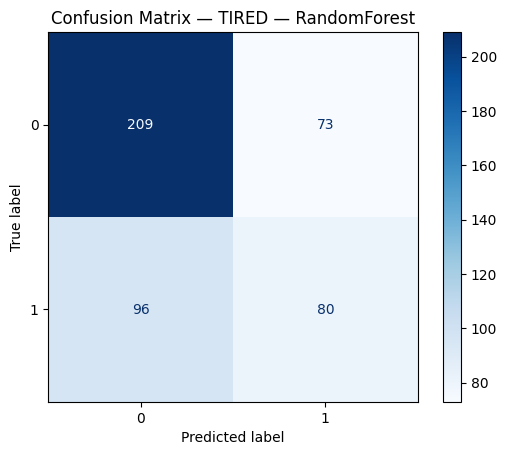

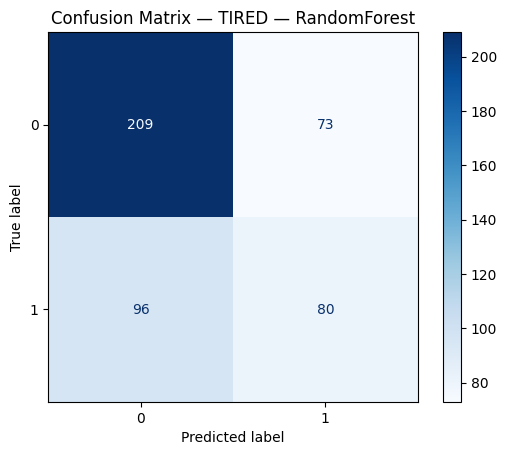

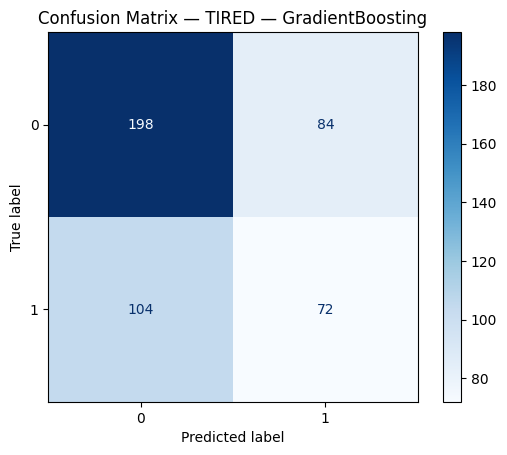

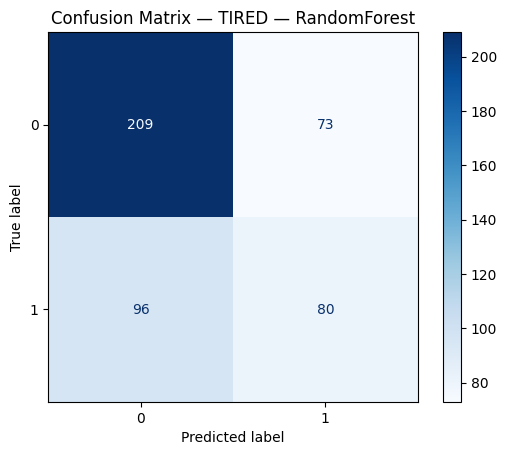

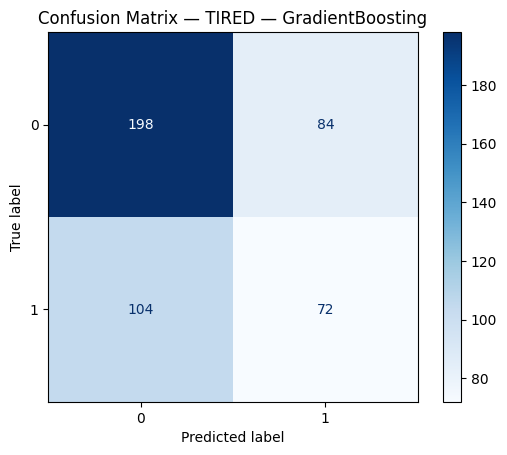

In [ ]:
tired_top5 = combined_results_sorted.head(5)

# Mostra la taula resum dels 5 millors
print(f"\nTop 5 models per a {TARGET} segons Test Accuracy:\n")
display(tired_top5[["Model","Test Accuracy","Test F1 (1)"]])

# Dibuixa la matriu de confusió de cada un
for model in tired_top5["Model"]:
    clf = base_models[model] 
    y_pred = clf.predict(X_test)  
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix — {TARGET} — {model}")
    plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve

# (1) Reserva un 15 % del train com a validació
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=42
)

best_rf = base_models["RandomForest"]
# (2) Reentrena el teu millor model només amb X_tr
best_rf.fit(X_tr, y_tr)

# (3) Probabilitats al set de validació
proba_val = best_rf.predict_proba(X_val)[:, 1]

# (4) Busquem el llindar que maximitzi F1
prec, rec, th = precision_recall_curve(y_val, proba_val)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_thr = th[f1.argmax()]
print(f"llindar òptim ≈ {best_thr:.2f}  —  F1_valid = {f1.max():.3f}")


In [ ]:
f1 = make_scorer(f1_score, pos_label=1)

clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "n_estimators": randint(300, 800),
    "max_depth":    randint(3, 8),
    "learning_rate": uniform(0.01, 0.19),
    "subsample":    uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "min_child_weight": randint(1, 6),
    "gamma": uniform(0, 0.3),
    "scale_pos_weight": [ (y_train==0).sum()/(y_train==1).sum() ]
}

pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", clf)
])

rs_xgb = RandomizedSearchCV(
    pipe, param_dist, n_iter=30, scoring=f1,
    cv=5, n_jobs=-1, random_state=42, refit=True
)

rs_xgb.fit(X_train, y_train,
           **{"classifier__eval_set": [(X_val, y_val)],
              "classifier__early_stopping_rounds": 40,
              "classifier__verbose": 0})